In [39]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import random

In [8]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = pd.read_csv(os.path.join(self.root_dir, csv_file))
        self.class_to_idx = {'dog': 0, 'cat': 1, 'horse': 2, 'spider': 3, 'butterfly': 4, 
                'chicken': 5, 'sheep': 6, 'cow': 7, 'squirrel': 8, 'elephant': 9}
        self.labels['label_idx'] = self.labels['label'].map(self.class_to_idx)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, f"{index}.png")
        image = Image.open(img_path).convert('RGB')
        label = self.labels.iloc[index, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images if they are not the same size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization parameters for pre-trained models
])

# Load the dataset
dataset = ImageDataset(csv_file='labels.csv', root_dir='generated_datasets/animals/kandinsky_2_2/256', transform=transform)

In [10]:
# Split the dataset into train and test sets
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=True)

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 10)  # 10 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 64 * 64)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
# Transfer the model to GPU if available
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)

In [13]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training pass
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation pass
    model.eval()
    val_running_loss = 0.0
    correct_preds = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_preds += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    val_loss = val_running_loss / len(test_loader)
    val_accuracy = correct_preds / len(test_loader)
    print(f'Epoch {epoch + 1}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

print('Finished Training')

Epoch 1, Training Loss: 1.746761154294014, Validation Loss: 0.1787763343891129, Validation Accuracy: 58.9375
Epoch 2, Training Loss: 0.0884137647151947, Validation Loss: 0.15777346258983016, Validation Accuracy: 59.375
Epoch 3, Training Loss: 0.04986320037767291, Validation Loss: 0.07621416580514051, Validation Accuracy: 61.0625
Epoch 4, Training Loss: 0.027653354768641294, Validation Loss: 0.07741049405012745, Validation Accuracy: 60.75
Epoch 5, Training Loss: 0.018700675542466343, Validation Loss: 0.05020180194696877, Validation Accuracy: 61.71875
Epoch 6, Training Loss: 0.0008369027953303885, Validation Loss: 0.03713299171607787, Validation Accuracy: 61.8125
Epoch 7, Training Loss: 0.00016429649664496536, Validation Loss: 0.034090723566805536, Validation Accuracy: 61.90625
Epoch 8, Training Loss: 9.634224938054103e-05, Validation Loss: 0.03374775175984723, Validation Accuracy: 61.90625
Epoch 9, Training Loss: 7.107714701123768e-05, Validation Loss: 0.03341654360701796, Validation Ac

In [49]:
def imshow(img, label, predicted_label):
    img = img.cpu()
    img = img.numpy().transpose((1, 2, 0))

    # Normalize the pixel values to [0, 1] for correct color representation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean

    plt.imshow(np.clip(img, 0, 1))
    plt.title(f"Actual: {label}, Predicted: {predicted_label}")
    plt.show()

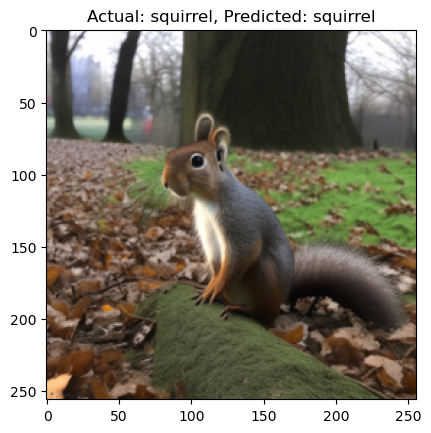

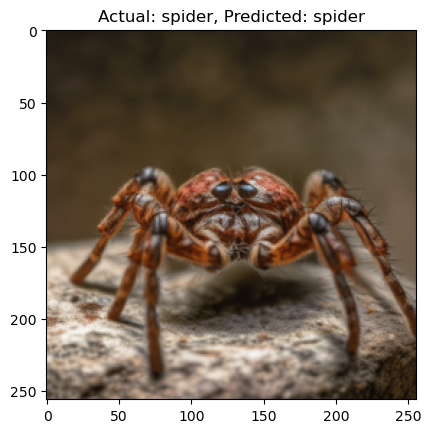

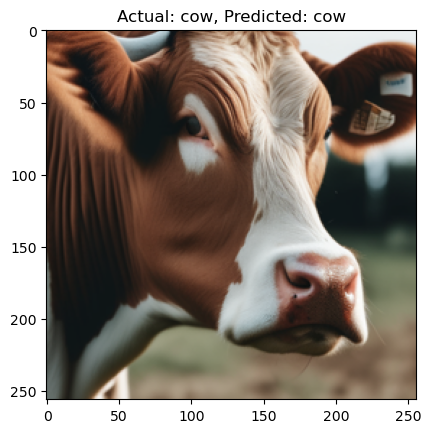

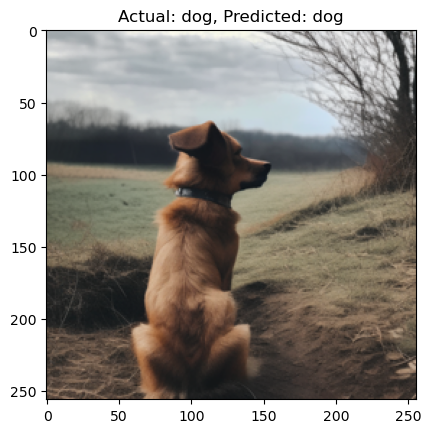

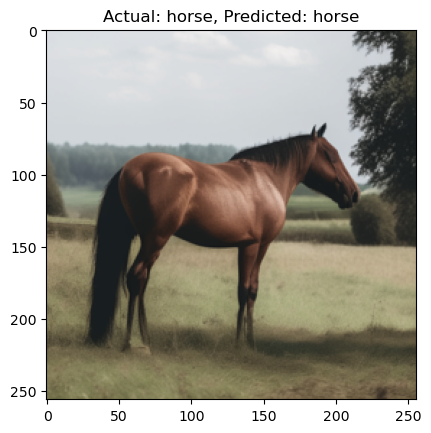

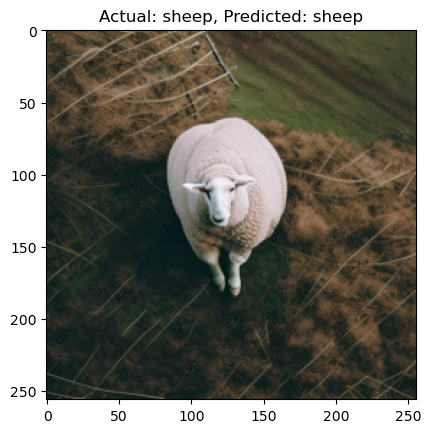

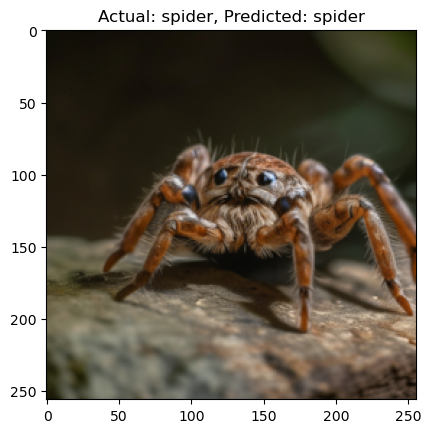

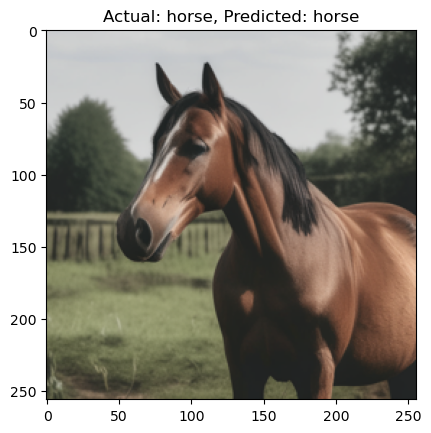

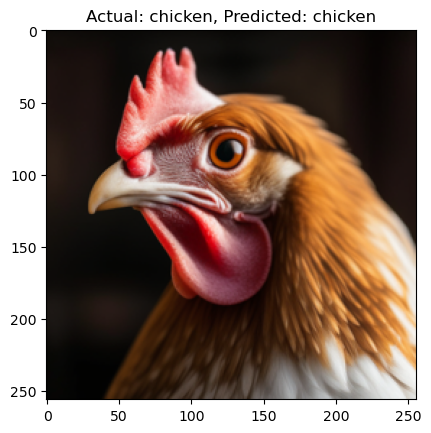

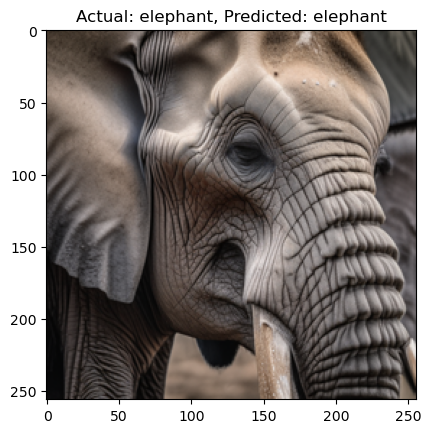

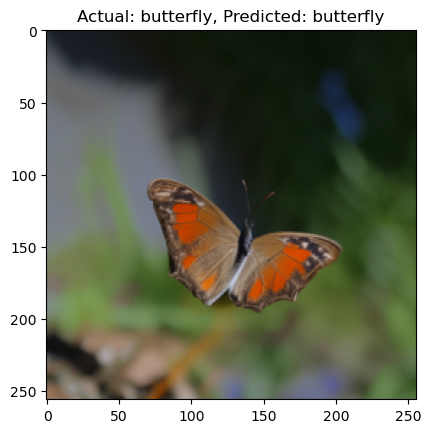

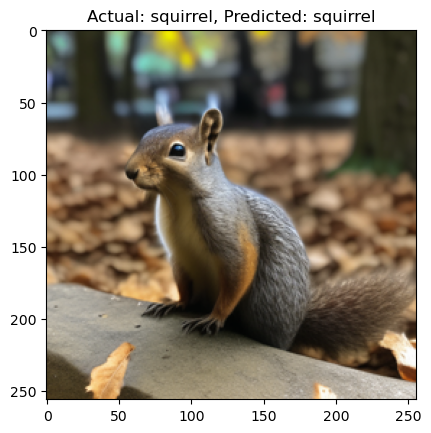

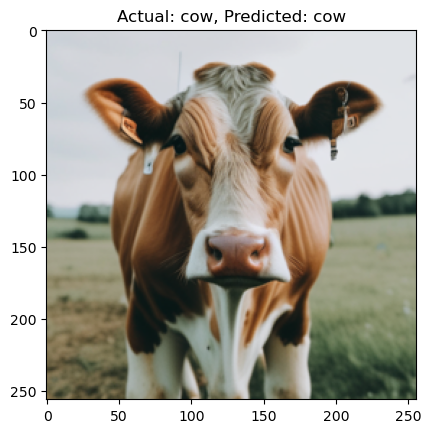

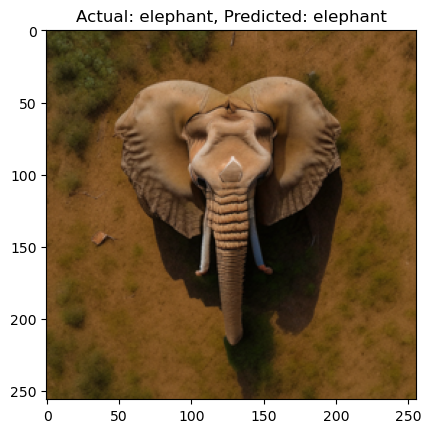

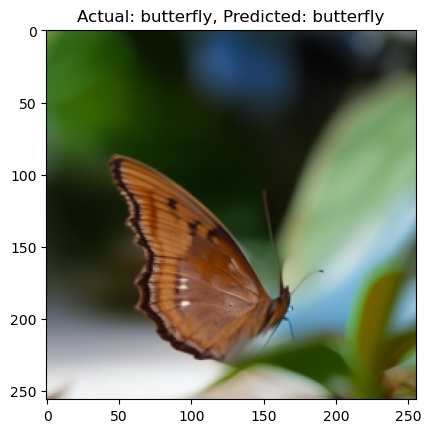

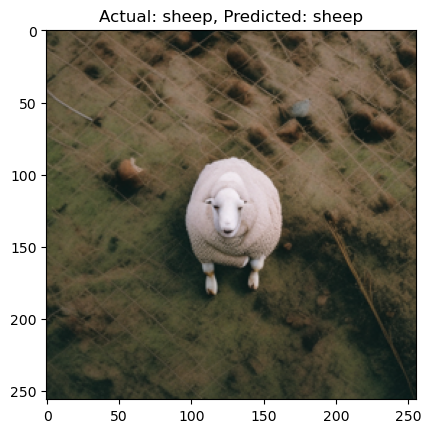

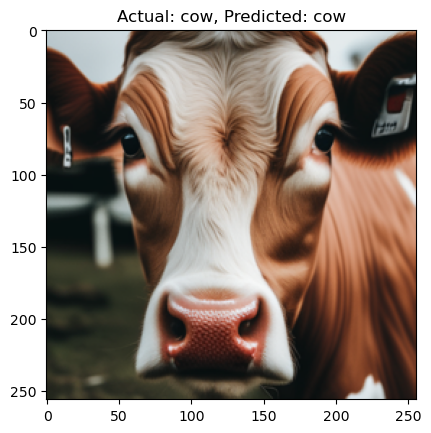

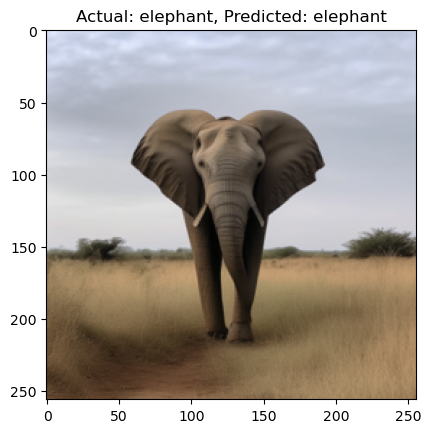

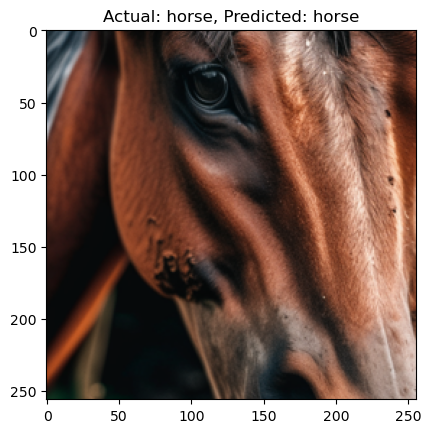

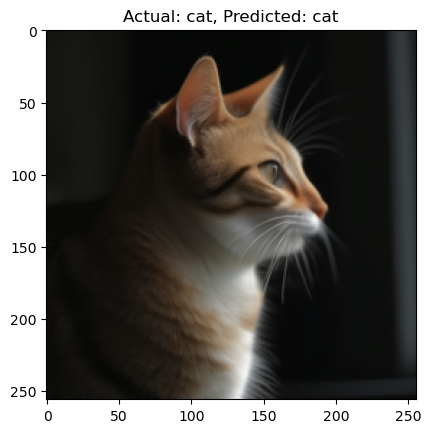

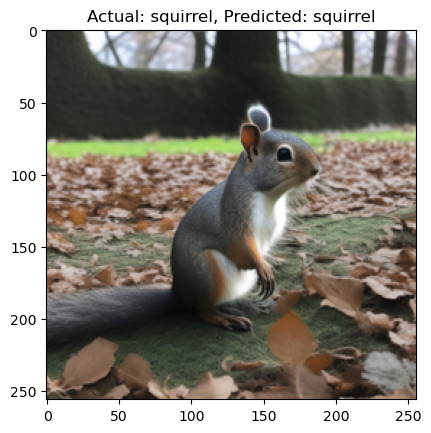

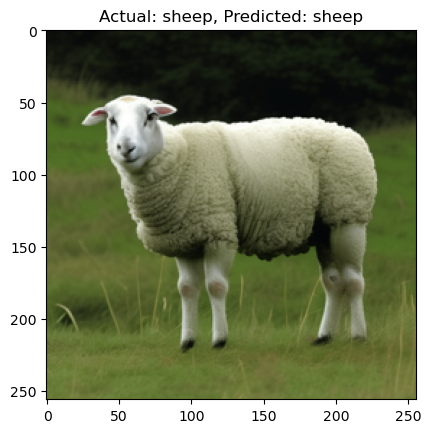

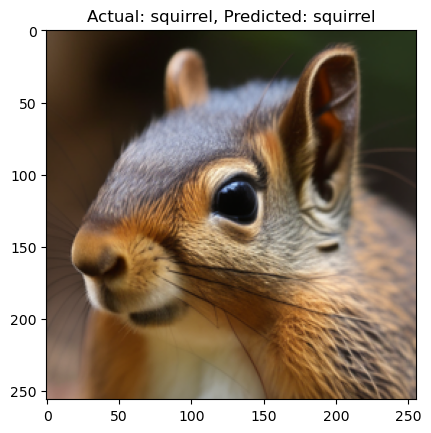

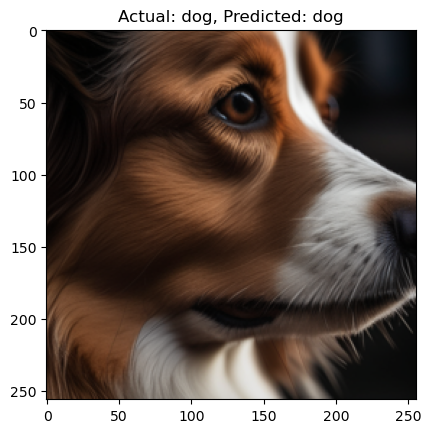

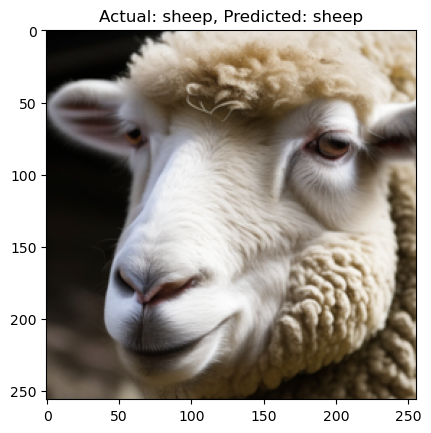

Accuracy of the model on the test images: 100.00%


In [37]:
# Function to convert numerical label to class name
def label_to_class_name(label_num):
    classes = ["dog", "cat", "horse", "spider", "butterfly", "chicken", "sheep", "cow", "squirrel", "elephant"]
    return classes[label_num]

# Set the model to evaluation mode
model.eval()

# Number of images to display
num_images_to_display = 5

correct = 0
total = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        if i >= num_images_to_display:
            break
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Check and move labels to CPU if on CUDA
        if labels.is_cuda:
            labels = labels.cpu()
        if predicted.is_cuda:
            predicted = predicted.cpu()

        for j in range(images.size()[0]):
            if j >= num_images_to_display:
                break

            imshow(images[j], label_to_class_name(labels[j]), label_to_class_name(predicted[j]))

# Calculate and print accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

In [38]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [40]:
dataset = datasets.ImageFolder(root='real_datasets/animals', transform=transform)

In [41]:
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

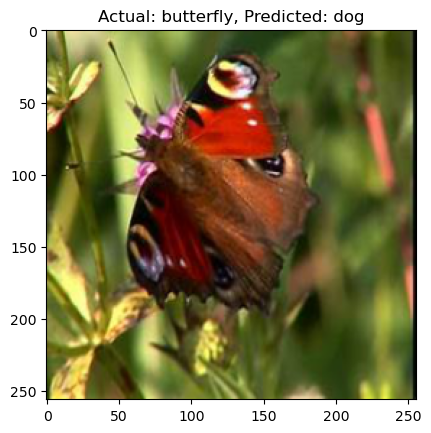

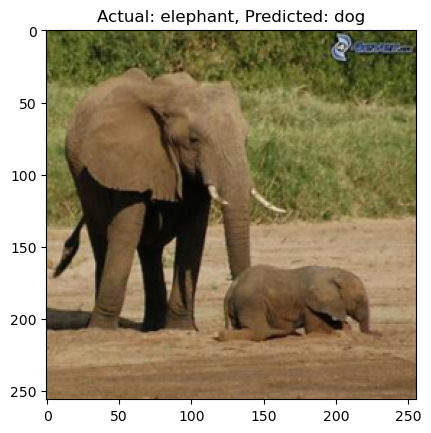

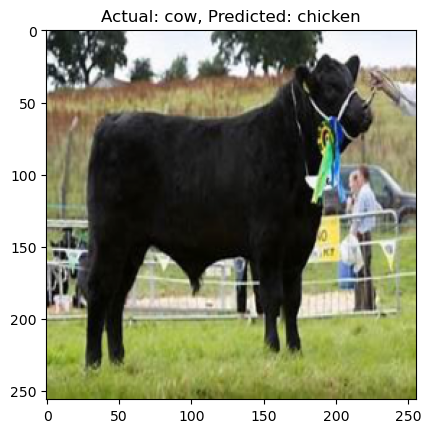

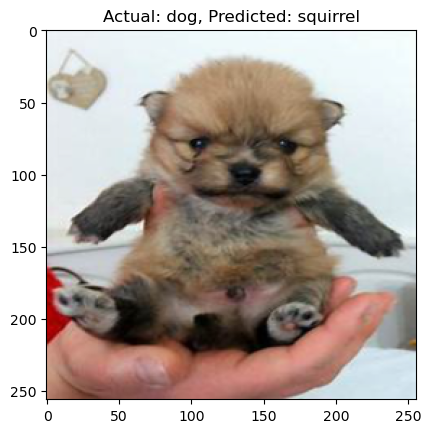

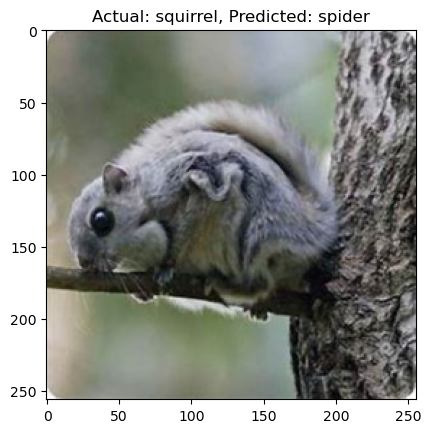

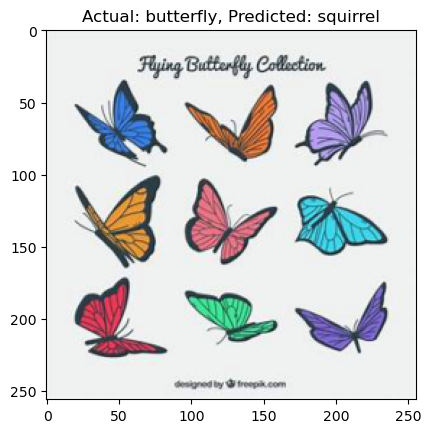

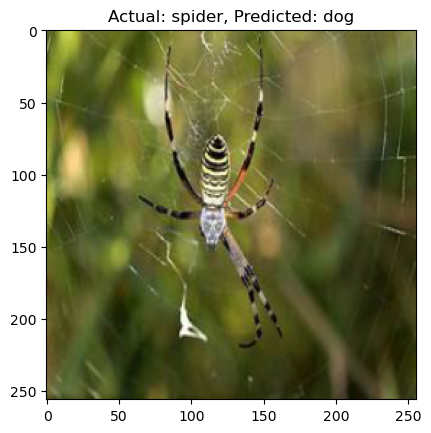

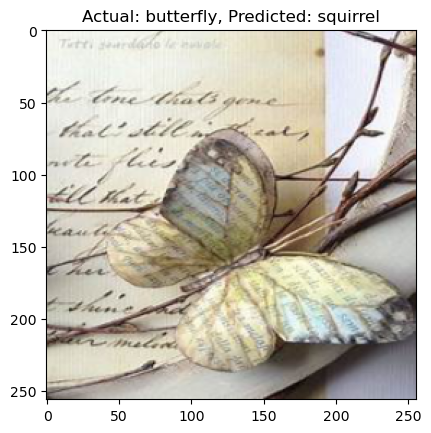

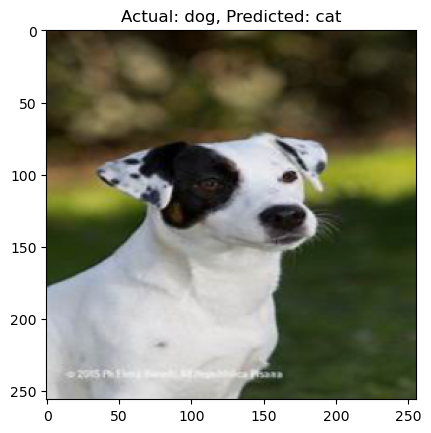

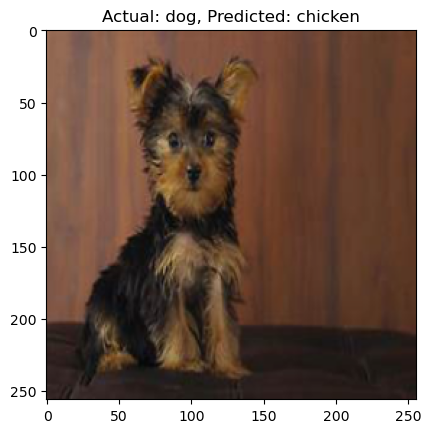

In [51]:
# Set the model to evaluation mode
model.eval()

# Number of images to display
num_images_to_display = 10

with torch.no_grad():
    for i, (images, labels) in enumerate(data_loader):
        if i >= num_images_to_display:
            break
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        imshow(images[0], dataset.classes[labels[0]],dataset.classes[predicted[0]])